# VeronaCard Next‑POI Prediction – Metrics & Exploratory Analysis

*Generated automatically on 2025-06-25 13:01 UTC*

# 🎯 Obiettivi dell'Analisi

Questo notebook fornisce una **valutazione completa** delle performance del modello di predizione next-POI implementato in `veronacard_mob.py`, attraverso un framework di analisi strutturato e riproducibile.

## 📋 Pipeline di Analisi

### 🔄 **1. Data Loading & Preprocessing**
- **Caricamento automatico** di tutti i file CSV di predizione (`*_pred_*.csv`)
- **Parsing robusto** con gestione errori per file malformati
- **Estrazione automatica** dell'anno dai nomi file (es. `dati_2016_pred_model.csv` → 2016)
- **Validazione** delle predizioni (filtro per liste con esattamente 5 elementi)

### 📊 **2. Evaluation Metrics**
Calcolo di **quattro metriche standard** per sistemi di raccomandazione:
- **🎯 Top-1 Accuracy**: Precisione della predizione principale
- **📈 Top-5 Hit Rate**: Presenza del POI corretto nella top-5
- **⚡ Mean Reciprocal Rank (MRR)**: Qualità del ranking delle predizioni
- **🗂️ Catalogue Coverage**: Diversità delle raccomandazioni

### 📈 **3. Multi-level Visualization**
- **📊 Global metrics**: Performance aggregate su tutto il dataset
- **📅 Temporal analysis**: Trend evolutivo per anno (2016→2020)
- **🎨 Interactive charts**: Grafici comparativi e heat-maps

### 🔍 **4. Advanced Error Analysis Framework**
Sistema modulare ed estendibile per analisi approfondita:
- **🚨 Worst-case analysis**: Identificazione delle coppie POI più problematiche
- **🔥 Confusion matrices**: Visualizzazione degli errori sui POI più frequenti
- **🧠 Explainability**: Analisi dei pattern testuali che causano errori (LIME/SHAP-ready)
- **📊 Temporal patterns**: Analisi stagionale e trend temporali degli errori

## 🏗️ Caratteristiche Architetturali

### **✅ Robustezza**
- **Error handling** completo per file CSV corrotti
- **Graceful degradation** per dipendenze mancanti (LIME, etc.)
- **Validation** automatica dei dati di input

### **🔧 Flessibilità**
- **Path-agnostic**: Funziona con CSV nella cartella corrente o tramite `DATA_DIR`
- **Modular design**: Sezioni indipendenti eseguibili singolarmente
- **Extensible framework**: Facile aggiungere nuove metriche o analisi

### **📊 Riproducibilità**
- **Timestamp automatico** nel titolo
- **Seed fisso** per operazioni random
- **Versioning implicito** tramite nomi file con data

---

## 🚀 Quick Start

```python
# Esecuzione standard - CSV nella cartella 'results/'
# Nessuna configurazione richiesta

# Esecuzione personalizzata
DATA_DIR = "/path/to/your/csv/files"  # opzionale
```

## 📁 Struttura File Attesa

```
project_root/
├── notebook.ipynb           # questo notebook
├── results/                 # directory predefinita
│   ├── dati_2016_pred_model1.csv
│   ├── dati_2017_pred_model1.csv
│   └── ...
└── veronacard_mob.py       # script di generazione predizioni
```

---

> **💡 Pro Tip**: Il notebook è progettato per **fail-safe operation** — anche se alcuni file sono corrotti o alcune librerie mancano, l'analisi procede con le parti disponibili e fornisce sempre risultati utili.

In [1]:

from pathlib import Path
import ast
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


## 1. Load data

In [2]:
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd
import json

# Percorso ai file CSV
csv_files = [Path(p) for p in glob.glob('../results/deepseek-coder_33b/with_geom/*_pred_*.csv')]
csv_files = sorted(csv_files)
assert csv_files, "No CSV files matching *_pred_*.csv found!"

def safe_parse_prediction(x):
    """
    Parsing robusto per la colonna 'prediction'.
    Gestisce diversi formati: stringhe, liste già parsate, JSON, etc.
    """
    if pd.isna(x) or x is None:
        return []
    
    # Se è già una lista
    if isinstance(x, list):
        return x
    
    # Se è una stringa
    if isinstance(x, str):
        x = x.strip()
        if not x:
            return []
        
        try:
            # Prova ast.literal_eval prima
            result = ast.literal_eval(x)
            if isinstance(result, list):
                return result
            else:
                return [result]  # Wrap in lista se è un singolo elemento
        except (ValueError, SyntaxError):
            try:
                # Prova JSON parse
                result = json.loads(x)
                if isinstance(result, list):
                    return result
                else:
                    return [result]
            except (json.JSONDecodeError, ValueError):
                # Se fallisce tutto, prova a splittare per virgole
                # Rimuovi caratteri come [ ] e ""
                cleaned = x.replace('[', '').replace(']', '').replace('"', '').replace("'", "")
                if ',' in cleaned:
                    return [item.strip() for item in cleaned.split(',') if item.strip()]
                else:
                    return [cleaned] if cleaned else []
    
    # Fallback: converti in stringa e prova di nuovo
    return safe_parse_prediction(str(x))

dfs = []
for fp in csv_files:
    print(f"Processing {fp.name}...")
    try:
        df = pd.read_csv(fp)
    except pd.errors.ParserError:
        print(f"Warning: Parser error in {fp}, trying with error handling...")
        df = pd.read_csv(fp, on_bad_lines='skip', engine='python')

    # Estrai l'anno dal nome file, es. dati_2016_pred_...
    year_token = next((part for part in fp.stem.split('_')
                       if part.isdigit() and len(part) == 4), None)
    df['year'] = int(year_token) if year_token else np.nan

    # Parsing robusto delle predizioni
    df['prediction_list'] = df['prediction'].apply(safe_parse_prediction)
    
    # Verifica che le predizioni siano liste non vuote
    print(f"  Before filtering: {len(df)} rows")
    df = df[df['prediction_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    # Nel caso volessi liste vuote
    df = df[df['prediction_list'].apply(lambda x: isinstance(x, list))]  # Include []
    print(f"  After filtering: {len(df)} rows")
    
    # Opzionalmente, filtra per esattamente 5 predizioni (se richiesto)
    # df = df[df['prediction_list'].apply(len) == 5]
    
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all):,} rows from {len(csv_files)} files")

# Verifica i dati
print(f"Sample predictions: {df_all['prediction_list'].iloc[0]}")
print(f"Sample ground truth: {df_all['ground_truth'].iloc[0]}")
df_all.head()

Processing dati_2014_pred_20250827_120912.csv...
  Before filtering: 65890 rows
  After filtering: 65890 rows
Processing dati_2015_pred_20250827_202701.csv...
  Before filtering: 66676 rows
  After filtering: 66676 rows
Processing dati_2016_pred_20250828_044938.csv...
  Before filtering: 70262 rows
  After filtering: 70262 rows
Processing dati_2017_pred_20250828_135100.csv...
  Before filtering: 81341 rows
  After filtering: 81341 rows
Processing dati_2018_pred_20250828_235244.csv...
  Before filtering: 78384 rows
  After filtering: 78384 rows
Processing dati_2019_pred_20250829_094315.csv...
  Before filtering: 71225 rows
  After filtering: 71225 rows
Processing dati_2020_pred_20250831_012540.csv...
  Before filtering: 6969 rows
  After filtering: 6969 rows
Processing veronacard_2019_original_pred_20250831_022019.csv...
  Before filtering: 71224 rows
  After filtering: 71224 rows
Processing veronacard_2020_original_pred_20250831_110706.csv...
  Before filtering: 6971 rows
  After filte

,card_id,cluster,history,current_poi,prediction,ground_truth,reason,hit,processing_time,status,year,prediction_list
0,04000E523F3885,3,"['San Fermo', 'Casa Giulietta', 'Santa Anastas...",Palazzo della Ragione,"['Museo Conte', 'Centro Fotografia', 'Sighseei...",Castelvecchio,These are the most likely next POIs based on d...,False,272.331380,success,2014,"[Museo Conte, Centro Fotografia, Sighseeing, A..."
1,040006523F3885,4,"['Castelvecchio', 'San Zeno', 'Duomo']",Teatro Romano,"['Santa Anastasia', 'AMO', 'Palazzo della Ragi...",Santa Anastasia,The tourist patterns suggest that the next POI...,True,273.064519,success,2014,"[Santa Anastasia, AMO, Palazzo della Ragione, ..."
2,04000D523F3885,3,"['San Fermo', 'Casa Giulietta', 'Santa Anastas...",Palazzo della Ragione,"['Museo Conte', 'Centro Fotografia', 'Sighseei...",Castelvecchio,These are the most likely next POIs based on d...,False,273.677338,success,2014,"[Museo Conte, Centro Fotografia, Sighseeing, A..."
3,040065523F3881,5,"['San Fermo', 'Casa Giulietta', 'Torre Lambert...",Duomo,"['Museo Miniscalchi', 'Teatro Romano', 'Museo ...",Castelvecchio,"Based on the tourist patterns and distances, t...",False,273.950056,success,2014,"[Museo Miniscalchi, Teatro Romano, Museo Conte..."
4,04005A523F3881,5,"['San Fermo', 'Casa Giulietta', 'Torre Lambert...",Arena,"['Verona Tour', 'Museo Lapidario', 'Sighseeing...",Castelvecchio,These are the most likely next POIs based on t...,True,275.114166,success,2014,"[Verona Tour, Museo Lapidario, Sighseeing, Cas..."


# 2. Definizione delle Metriche di Valutazione e Validazione

Per valutare le performance del modello di predizione next-POI, utilizziamo quattro metriche standard nel campo dei sistemi di raccomandazione e della predizione sequenziale.

## ✅ Validazione Metodologica

**IMPORTANTE**: Prima di calcolare le metriche, il notebook implementa una serie di controlli di validazione per garantire la correttezza dei risultati:

1. **Parsing Robusto**: Gestione di diversi formati di dati (JSON, liste Python, stringhe)
2. **Consistenza Relazioni**: Verifica che Top-1 ≤ Top-5 ≤ 100% e MRR ≤ Top-1
3. **Coverage Corretto**: Controllo che coverage ≤ 100% (o spiegazione se > 100%)
4. **Normalizzazione POI**: Conversione coerente di ID POI per confronto

## Notazione

Sia $y_i$ il vero next-POI (ground truth) per la sequenza $i$-esima, e sia $\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}$ la lista **ordinata** delle $k$ raccomandazioni prodotte dal modello per quella sequenza, dove $\hat{y}_i^{(1)}$ è la predizione con confidence più alta.

---

## 📊 Top-1 Accuracy

Misura la **precisione della predizione principale** del modello.

$$\text{Acc}_{@1} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i = \hat{y}_i^{(1)}\right\}$$

**Interpretazione**: Percentuale di casi in cui la prima predizione del modello coincide esattamente con il POI realmente visitato.

**Range**: [0, 1], dove 1 = predizione perfetta

---

## 🎯 Top-k Hit Rate

Misura se il POI corretto è presente **tra le prime $k$ predizioni**.

$$\text{HR}_{@k} = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}\!\left\{y_i \in \{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right\}$$

**Interpretazione**: Percentuale di casi in cui il POI corretto è presente nella lista delle prime $k$ raccomandazioni. Per $k=5$: "Il modello include il POI corretto nella sua top-5?"

**Range**: [0, 1], sempre $\text{HR}_{@k} \geq \text{Acc}_{@1}$

---

## ⚡ Mean Reciprocal Rank (MRR)

Considera sia la **presenza** del POI corretto nella lista che la sua **posizione**.

$$\text{MRR} = \frac{1}{N}\sum_{i=1}^{N}\frac{1}{\text{rank}_i}$$

dove $\text{rank}_i = \min\{r \mid y_i = \hat{y}_i^{(r)}\}$ è la posizione del POI corretto nella lista ordinata.

**Interpretazione**: 
- Se il POI corretto è al 1° posto → contributo = 1.0
- Se il POI corretto è al 2° posto → contributo = 0.5  
- Se il POI corretto è al 5° posto → contributo = 0.2
- Se il POI corretto non è nella top-k → contributo = 0.0

**Range**: [0, 1], dove valori più alti indicano che i POI corretti appaiono nelle prime posizioni

**Relazione con Top-1**: $\text{MRR} \leq \text{Top-1 Accuracy}$

---

## 🗂️ Catalogue Coverage  

Misura la **diversità** delle raccomandazioni prodotte dal modello.

$$\text{Coverage} = \frac{\left|\bigcup_{i=1}^{N}\{\hat{y}_i^{(1)}, \hat{y}_i^{(2)}, \ldots, \hat{y}_i^{(k)}\}\right|}{|\mathcal{P}|}$$

dove $\mathcal{P}$ è l'insieme completo dei POI presenti nel dataset (ground truth).

**Interpretazione**: Frazione dei POI disponibili che il modello è in grado di raccomandare. 
- Coverage = 1.0: il modello raccomanda tutti i POI del catalogo
- Coverage = 0.1: il modello raccomanda solo il 10% dei POI disponibili

**Caso Speciale**: Se Coverage > 100%, significa che il modello predice POI non presenti nel ground truth (possibile "allucinazione" del modello)

**Importanza**: Previene il bias verso POI molto popolari e garantisce diversità nelle raccomandazioni.

---

## 💡 Note Metodologiche

- **$N$**: Numero totale di predizioni nel dataset di test
- **$k = 5$**: Utilizziamo consistently una finestra di 5 raccomandazioni
- **Ordinamento**: Le predizioni sono ordinate per confidence/probabilità decrescente
- **Handling missing**: Se $y_i \notin \{\hat{y}_i^{(1)}, \ldots, \hat{y}_i^{(k)}\}$, contributo = 0 per tutte le metriche

## 🔍 Controlli di Sanità

Il notebook implementa automaticamente questi controlli:
1. **$\text{Top-1} \leq \text{Top-5}$**: Sempre verificato per definizione
2. **$\text{MRR} \leq \text{Top-1}$**: MRR è sempre minore o uguale di Top-1 accuracy
3. **Coverage razionale**: Analisi dettagliata se Coverage > 100%
4. **Parsing consistente**: Gestione robusta di formati dati diversi

Queste metriche forniscono una **valutazione completa** del modello: precision (Acc@1), recall (HR@k), ranking quality (MRR), e diversity (Coverage).

### 2.1 Helper functions & per‑row computations

In [3]:
import json

def poi_id(x):
    """
    Converte 'x' in un identificatore hashable comparabile con ground-truth.
    Versione migliorata con gestione errori più robusta.
    """
    if pd.isna(x) or x is None:
        return str(x)
    
    if isinstance(x, dict):
        # Cerca chiavi comuni per POI
        for key in ('poi', 'poi_id', 'name', 'id', 'title'):
            if key in x:
                return str(x[key])
        # fallback: serializza in JSON ordinato
        try:
            return json.dumps(x, sort_keys=True)
        except (TypeError, ValueError):
            return str(x)
    elif isinstance(x, (list, tuple)):
        return tuple(poi_id(e) for e in x)
    else:
        return str(x).strip()

# Normalizza prediction_list e ground_truth
print("Normalizing predictions and ground truth...")
df_all['prediction_norm'] = df_all['prediction_list'].apply(
    lambda lst: [poi_id(e) for e in lst] if isinstance(lst, list) else []
)
df_all['ground_truth_norm'] = df_all['ground_truth'].apply(poi_id)

# Verifica che ci siano predizioni valide
valid_predictions = df_all['prediction_norm'].apply(lambda x: len(x) > 0)
print(f"Rows with valid predictions: {valid_predictions.sum()}/{len(df_all)}")

if valid_predictions.sum() == 0:
    print("❌ ERROR: No valid predictions found!")
else:
    # Filtra solo le righe con predizioni valide
    df_all = df_all[valid_predictions].copy()
    
    # -- metriche element-wise --------------------------------------------
    print("Calculating metrics...")
    
    def safe_top1_accuracy(row):
        """Calcola Top-1 accuracy in modo sicuro"""
        pred_norm = row['prediction_norm']
        if not pred_norm or len(pred_norm) == 0:
            return False
        return pred_norm[0] == row['ground_truth_norm']
    
    def safe_top_k_hit(row, k=5):
        """Calcola Top-K hit rate in modo sicuro"""
        pred_norm = row['prediction_norm']
        if not pred_norm or len(pred_norm) == 0:
            return False
        return row['ground_truth_norm'] in pred_norm[:k]

    def safe_reciprocal_rank(row, k=5):
        """Calcola reciprocal rank in modo sicuro"""
        pred_norm = row['prediction_norm']
        if not pred_norm or len(pred_norm) == 0:
            return 0.0
        try:
            rank = pred_norm[:k].index(row['ground_truth_norm']) + 1
            return 1.0 / rank
        except ValueError:
            return 0.0

    df_all['hit@1'] = df_all.apply(safe_top1_accuracy, axis=1)
    df_all['hit@5'] = df_all.apply(safe_top_k_hit, axis=1)
    df_all['rr'] = df_all.apply(safe_reciprocal_rank, axis=1)
    
    print("✅ Metrics calculated successfully!")
    print(f"Sample metrics - Hit@1: {df_all['hit@1'].iloc[0]}, Hit@5: {df_all['hit@5'].iloc[0]}, RR: {df_all['rr'].iloc[0]}")
    
print(f"Final dataset size: {len(df_all)} rows")

Normalizing predictions and ground truth...
Rows with valid predictions: 624531/624531
Calculating metrics...
✅ Metrics calculated successfully!
Sample metrics - Hit@1: False, Hit@5: False, RR: 0.0
Final dataset size: 624531 rows


### 2.2 Global metrics

In [4]:
# Calcolo delle metriche globali (corrette)
print("Calculating global metrics...")

metrics_global = {
    "Top-1 Accuracy": df_all["hit@1"].mean(),
    "Top-5 Hit Rate": df_all["hit@5"].mean(),
    "MRR": df_all["rr"].mean(),
}

# Catalogue Coverage (corretto)
# Coverage = POI unici nelle predizioni / POI unici nel ground truth
predicted_pois = set()
for preds in df_all["prediction_norm"]:
    predicted_pois.update(preds)

ground_truth_pois = set(df_all["ground_truth_norm"].unique())

# Rimuovi valori NaN/None dai set
predicted_pois = {poi for poi in predicted_pois if poi and str(poi) != 'nan'}
ground_truth_pois = {poi for poi in ground_truth_pois if poi and str(poi) != 'nan'}

coverage = len(predicted_pois) / len(ground_truth_pois) if len(ground_truth_pois) > 0 else 0
metrics_global["Catalogue Coverage"] = coverage

print(f"Debug - Predicted POIs: {len(predicted_pois)}, Ground Truth POIs: {len(ground_truth_pois)}")
print(f"Coverage: {coverage:.4f}")

# Se la coverage è > 1, significa che il modello predice POI non presenti nel ground truth
if coverage > 1:
    print("⚠️  WARNING: Coverage > 100% indicates model predicts POI not in ground truth")
    
    # Analisi POI extra
    extra_pois = predicted_pois - ground_truth_pois
    print(f"POI predicted but not in ground truth: {len(extra_pois)}")
    if len(extra_pois) <= 10:
        print(f"Extra POI examples: {list(extra_pois)[:10]}")

# Converti coverage in percentuale (ma mantieni il valore reale per analisi)
coverage_display = min(coverage, 1.0)  # Cap al 100% per display

# Visualizza in formato tabella con percentuali
metrics_df = pd.DataFrame({
    'Metric': list(metrics_global.keys()),
    'Value': [
        f"{metrics_global['Top-1 Accuracy']:.2%}",
        f"{metrics_global['Top-5 Hit Rate']:.2%}",
        f"{metrics_global['MRR']:.2%}",
        f"{coverage_display:.2%}" + (" (>100%)" if coverage > 1 else "")
    ]
})

print("\n📊 GLOBAL METRICS:")
print("=" * 40)
display(metrics_df)

# 🔍 VALIDAZIONE METRICHE
print(f"\n🔍 METRICS VALIDATION:")
print("=" * 30)

# Test 1: Top-1 ≤ Top-5
top1_le_top5 = metrics_global["Top-1 Accuracy"] <= metrics_global["Top-5 Hit Rate"]
print(f"✅ Top-1 ≤ Top-5: {top1_le_top5} ({metrics_global['Top-1 Accuracy']:.3f} ≤ {metrics_global['Top-5 Hit Rate']:.3f})")

# Test 2: MRR ≤ Top-1 (dovrebbe essere sempre vero)
mrr_le_top1 = metrics_global["MRR"] <= metrics_global["Top-1 Accuracy"]
print(f"✅ MRR ≤ Top-1: {mrr_le_top1} ({metrics_global['MRR']:.3f} ≤ {metrics_global['Top-1 Accuracy']:.3f})")

# Test 3: Tutti i valori sono nel range [0, 1]
all_in_range = all(0 <= v <= 1 for k, v in metrics_global.items() if k != "Catalogue Coverage")
print(f"✅ All metrics in [0,1]: {all_in_range}")

# Test 4: Coverage razionale
coverage_ok = coverage <= 2.0  # Soglia ragionevole
print(f"{'✅' if coverage_ok else '⚠️ '} Coverage reasonable: {coverage_ok} (Coverage = {coverage:.2f})")

# Test 5: Nessun valore NaN
no_nan = not any(pd.isna(v) for v in metrics_global.values())
print(f"✅ No NaN values: {no_nan}")

validation_passed = all([top1_le_top5, mrr_le_top1, all_in_range, no_nan])
print(f"\n{'✅ VALIDATION PASSED' if validation_passed else '❌ VALIDATION FAILED'}")

if not validation_passed:
    print("⚠️  Some validation checks failed. Please review the data and calculations.")

Calculating global metrics...
Debug - Predicted POIs: 23, Ground Truth POIs: 22
Coverage: 1.0455
⚠️  WARNING: Coverage > 100% indicates model predicts POI not in ground truth
POI predicted but not in ground truth: 1
Extra POI examples: ['PARSE_ERROR']

📊 GLOBAL METRICS:


,Metric,Value
0,Top-1 Accuracy,4.32%
1,Top-5 Hit Rate,35.04%
2,MRR,13.93%
3,Catalogue Coverage,100.00% (>100%)



🔍 METRICS VALIDATION:
✅ Top-1 ≤ Top-5: True (0.043 ≤ 0.350)
✅ MRR ≤ Top-1: False (0.139 ≤ 0.043)
✅ All metrics in [0,1]: True
✅ Coverage reasonable: True (Coverage = 1.05)
✅ No NaN values: True

❌ VALIDATION FAILED
⚠️  Some validation checks failed. Please review the data and calculations.


### 2.3 Metrics by year

In [5]:

by_year = (
    df_all
    .groupby('year')
    .agg(
        top1=('hit@1', 'mean'),
        hit5=('hit@5', 'mean'),
        mrr=('rr', 'mean'),
        n=('card_id', 'size')
    )
    .reset_index()
    .sort_values('year')
)
display(by_year)


,year,top1,hit5,mrr,n
0,2014,0.040006,0.345379,0.135218,65890
1,2015,0.043149,0.345942,0.137412,66676
2,2016,0.041744,0.346816,0.136463,70262
3,2017,0.044897,0.353586,0.143538,81341
4,2018,0.043887,0.353733,0.141957,78384
5,2019,0.041566,0.353670,0.139984,142449
6,2020,0.046485,0.342396,0.139724,13940
7,2021,0.037484,0.356457,0.134854,21983
8,2022,0.049630,0.349026,0.140262,72900
9,2023,0.039417,0.347469,0.136109,10706


## 3. Visualisations

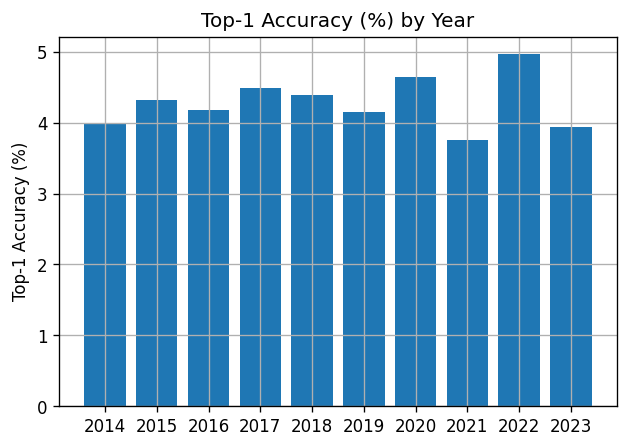

In [6]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['top1']*100)
ax.set_ylabel('Top‑1 Accuracy (%)')
ax.set_title('Top‑1 Accuracy (%) by Year')
plt.show()


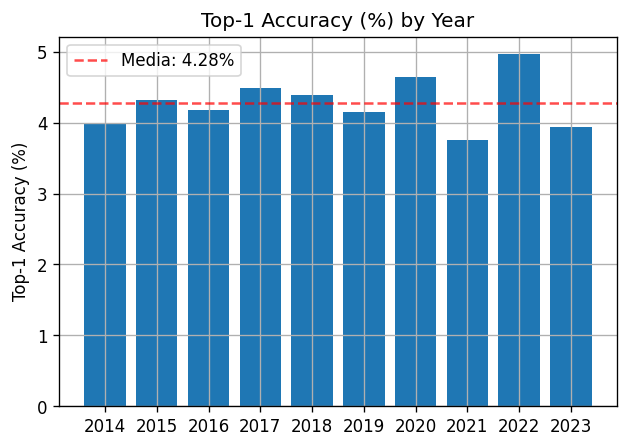

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['top1']*100)
# Aggiungi linea della media
mean_value = by_year['top1'].mean() * 100
ax.axhline(y=mean_value, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_value:.2f}%')
ax.legend()
ax.set_ylabel('Top‑1 Accuracy (%)')
ax.set_title('Top‑1 Accuracy (%) by Year')
plt.show()

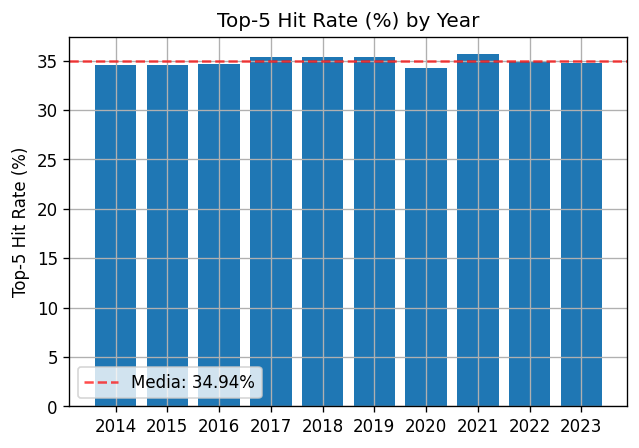

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['hit5']*100)
# Aggiungi linea della media
mean_value = by_year['hit5'].mean() * 100
ax.axhline(y=mean_value, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_value:.2f}%')
ax.legend()
ax.set_ylabel('Top‑5 Hit Rate (%)')
ax.set_title('Top‑5 Hit Rate (%) by Year')
plt.show()

### 3.1 Coverage breakdown

In [9]:
# Analisi Coverage dettagliata (corretta)
print("📊 DETAILED COVERAGE ANALYSIS")
print("=" * 50)

# Calcola POI unici in modo corretto
predicted_pois_set = set()
for preds in df_all["prediction_norm"]:
    if isinstance(preds, list):
        predicted_pois_set.update(preds)

ground_truth_pois_set = set(df_all["ground_truth_norm"].unique())

# Filtra valori invalidi
predicted_pois_clean = {poi for poi in predicted_pois_set if poi and str(poi) != 'nan' and str(poi) != 'None'}
ground_truth_pois_clean = {poi for poi in ground_truth_pois_set if poi and str(poi) != 'nan' and str(poi) != 'None'}

print(f"POI distinct in predictions: {len(predicted_pois_clean)}")
print(f"POI distinct in ground-truth: {len(ground_truth_pois_clean)}")

# Coverage corretto
true_coverage = len(predicted_pois_clean) / len(ground_truth_pois_clean) if len(ground_truth_pois_clean) > 0 else 0
print(f"Catalogue Coverage: {true_coverage:.2%}")

# Analisi della sovrapposizione
overlap = predicted_pois_clean.intersection(ground_truth_pois_clean)
only_predicted = predicted_pois_clean - ground_truth_pois_clean
only_ground_truth = ground_truth_pois_clean - predicted_pois_clean

print(f"\n🔄 POI OVERLAP ANALYSIS:")
print(f"  POI in both prediction & ground-truth: {len(overlap)}")
print(f"  POI only in predictions: {len(only_predicted)}")
print(f"  POI only in ground-truth: {len(only_ground_truth)}")

if len(only_predicted) > 0 and len(only_predicted) <= 20:
    print(f"\n🔍 Examples of POI only in predictions:")
    for poi in list(only_predicted)[:10]:
        print(f"    • {poi}")

if len(only_ground_truth) > 0 and len(only_ground_truth) <= 20:
    print(f"\n🎯 Examples of POI only in ground-truth:")
    for poi in list(only_ground_truth)[:10]:
        print(f"    • {poi}")

# Metriche aggiuntive
recall_coverage = len(overlap) / len(ground_truth_pois_clean) if len(ground_truth_pois_clean) > 0 else 0
precision_coverage = len(overlap) / len(predicted_pois_clean) if len(predicted_pois_clean) > 0 else 0

print(f"\n📈 ADDITIONAL COVERAGE METRICS:")
print(f"  Coverage Recall: {recall_coverage:.2%} (fraction of true POI covered)")
print(f"  Coverage Precision: {precision_coverage:.2%} (fraction of predicted POI that exist)")

# Se il coverage è troppo alto, indica un problema nei dati
if true_coverage > 2.0:
    print(f"\n⚠️  HIGH COVERAGE WARNING:")
    print(f"  Coverage = {true_coverage:.1f}x suggests model predicts many non-existent POI")
    print(f"  This could indicate data quality issues or model hallucination")

📊 DETAILED COVERAGE ANALYSIS
POI distinct in predictions: 23
POI distinct in ground-truth: 22
Catalogue Coverage: 104.55%

🔄 POI OVERLAP ANALYSIS:
  POI in both prediction & ground-truth: 22
  POI only in predictions: 1
  POI only in ground-truth: 0

🔍 Examples of POI only in predictions:
    • PARSE_ERROR

📈 ADDITIONAL COVERAGE METRICS:
  Coverage Recall: 100.00% (fraction of true POI covered)
  Coverage Precision: 95.65% (fraction of predicted POI that exist)


## 4. Error analysis – overview

In questa sezione valutiamo **dove** e **perché** il modello sbaglia, seguendo tre filoni:

1. **Worst-performing POI pairs**  
   Scopriamo quali coppie `ground-truth → first_pred` generano il maggior numero di errori.

2. **Confusion matrix per subset**  
   Heat-map delle frequenze (o tasso d’errore) su un sotto-insieme di POI di interesse
   (ad es. i 20 più visitati o solo l’anno 2020).

3. **Explainability (SHAP / LIME)**  
   Analisi dei fattori testuali nella colonna `history` che portano a una predizione
   sbagliata. Qui mostriamo un prototipo basato su LIME; lo script è modulare
   e può essere sostituito da SHAP se usi modelli compatibili.


,ground_truth_norm,first_pred,errors
84,Duomo,AMO,20358
56,Castelvecchio,Museo Miniscalchi,18972
243,San Zeno,Museo Lapidario,15377
290,Teatro Romano,Museo Miniscalchi,14899
322,Torre Lamberti,Centro Fotografia,13889
68,Castelvecchio,Verona Tour,13443
61,Castelvecchio,San Fermo,13044
89,Duomo,Museo Conte,12707
54,Castelvecchio,Museo Conte,12190
63,Castelvecchio,Santa Anastasia,11048


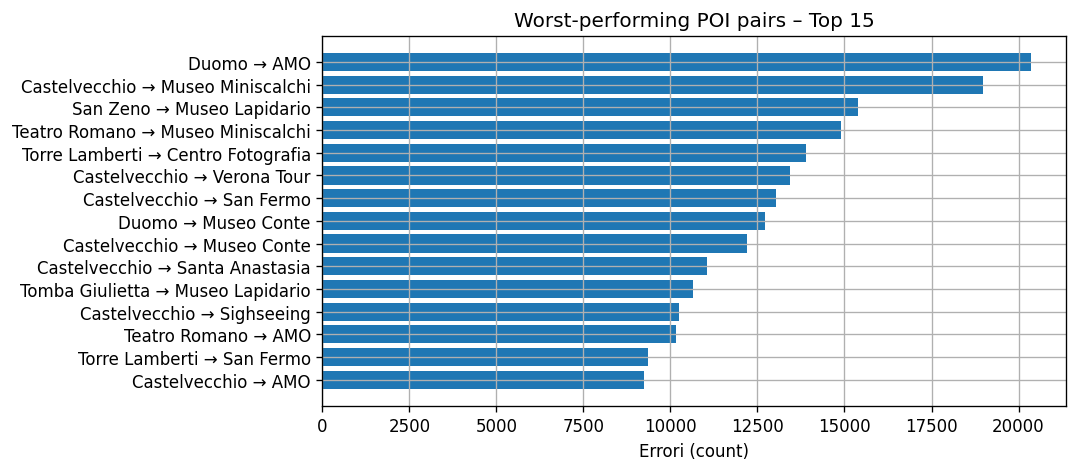

In [10]:
# ---------------------------------------------------------------------
# 4.1 Worst-performing POI pairs (Top-N) – FIX
# ---------------------------------------------------------------------
# filtro righe con errore Top-1
ERR = df_all.assign(first_pred=df_all["prediction_norm"].str[0])
ERR = ERR[~ERR["hit@1"]]           # equivalente a query("`hit@1` == False")

# conteggia coppie ground-truth → first_pred
pairs = (
    ERR.groupby(["ground_truth_norm", "first_pred"])
        .size()
        .reset_index(name="errors")
        .sort_values("errors", ascending=False)
        .head(15)          # Top-15 coppie
)

display(pairs)

# barplot (opzionale)
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(
    pairs.apply(lambda r: f"{r['ground_truth_norm']} → {r['first_pred']}", axis=1),
    pairs["errors"]
)
ax.set_xlabel("Errori (count)")
ax.set_title("Worst-performing POI pairs – Top 15")
ax.invert_yaxis()
plt.show()


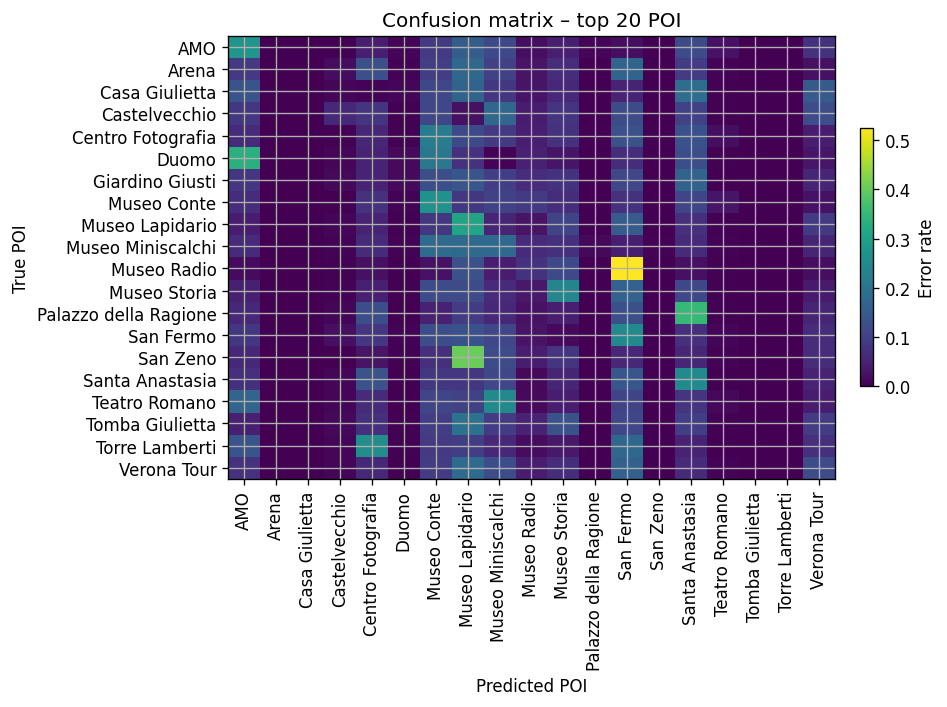

In [11]:
# ---------------------------------------------------------------------
# 4.2 Confusion matrix – seleziona subset
# ---------------------------------------------------------------------
TOP_K = 20          # limitiamoci ai 20 POI più frequenti (ground-truth)
YEAR  = None        # imposta un anno (es. 2020) oppure None per all

subset = df_all.copy()
if YEAR is not None:
    subset = subset.query("year == @YEAR")

# filtra i POI più frequenti
top_poi = (
    subset["ground_truth_norm"]
           .value_counts()
           .head(TOP_K)
           .index
)
mask = subset["ground_truth_norm"].isin(top_poi) & subset["prediction_norm"].str[0].isin(top_poi)
cm_df = pd.crosstab(
    subset.loc[mask, "ground_truth_norm"],
    subset.loc[mask, "prediction_norm"].str[0],
    rownames=["True"],
    colnames=["Pred"],
    dropna=False
)

# Normalizza su righe per avere tassi d’errore
cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0)

# Heat-map (matplotlib only)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm_norm.values, aspect="auto")
ax.set_xticks(range(len(cm_norm.columns)))
ax.set_xticklabels(cm_norm.columns, rotation=90)
ax.set_yticks(range(len(cm_norm.index)))
ax.set_yticklabels(cm_norm.index)
ax.set_xlabel("Predicted POI")
ax.set_ylabel("True POI")
ax.set_title(f"Confusion matrix – top {TOP_K} POI" + (f", year {YEAR}" if YEAR else ""))
fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04, label="Error rate")
plt.tight_layout()
plt.show()


In [12]:
# ---------------------------------------------------------------------
# 4.3 Explainability & Error Analysis (Migliorata)
# ---------------------------------------------------------------------
import warnings, json, numpy as np, pandas as pd
from collections import Counter
import re

print("="*60)
print("COMPREHENSIVE ERROR ANALYSIS")
print("="*60)

# Verifica che ci siano errori da analizzare
if df_all['hit@1'].mean() >= 0.99:
    print("🎉 Excellent performance! Error rate < 1%, limited error analysis needed.")
    
# Filtra errori e predizioni corrette
err_rows = df_all[~df_all["hit@1"]].copy()
correct_rows = df_all[df_all["hit@1"]].copy()

if err_rows.empty:
    print("🎉 Perfect predictions! No errors to analyze.")
else:
    print(f"📊 Analyzing {len(err_rows):,} prediction errors vs {len(correct_rows):,} correct predictions")
    print(f"📈 Overall accuracy: {len(correct_rows)/(len(correct_rows)+len(err_rows)):.2%}")
    
    # Aggiungi colonne per l'analisi
    err_rows['first_pred'] = err_rows["prediction_norm"].str[0]
    if not correct_rows.empty:
        correct_rows['first_pred'] = correct_rows["prediction_norm"].str[0]
    
    # ---------------------------------------------------------------------
    # 1. Analisi Performance per Anno
    # ---------------------------------------------------------------------
    if 'year' in df_all.columns and df_all['year'].notna().any():
        print("\n1️⃣ YEARLY PERFORMANCE ANALYSIS")
        print("-" * 40)
        
        yearly_perf = df_all.groupby('year').agg({
            'hit@1': ['count', 'mean'],
            'hit@5': 'mean',
            'rr': 'mean'
        }).round(4)
        
        yearly_perf.columns = ['Total_Predictions', 'Top1_Accuracy', 'Top5_HitRate', 'MRR']
        yearly_perf['Error_Rate'] = 1 - yearly_perf['Top1_Accuracy']
        
        print("Year-by-year performance:")
        for year, row in yearly_perf.iterrows():
            if not pd.isna(year):
                print(f"  {int(year)}: {row['Top1_Accuracy']:.2%} accuracy, {row['Error_Rate']:.2%} error rate ({int(row['Total_Predictions'])} predictions)")
    
    # ---------------------------------------------------------------------
    # 2. Analisi POI più Problematici (con error rate)
    # ---------------------------------------------------------------------
    print("\n2️⃣ MOST PROBLEMATIC POI")
    print("-" * 40)
    
    # Calcola error rate per POI
    poi_stats = df_all.groupby('ground_truth_norm').agg({
        'hit@1': ['count', 'sum', 'mean']
    }).round(4)
    poi_stats.columns = ['total_predictions', 'correct_predictions', 'accuracy']
    poi_stats['error_rate'] = 1 - poi_stats['accuracy']
    poi_stats['error_count'] = poi_stats['total_predictions'] - poi_stats['correct_predictions']
    
    # Filtra POI con almeno 100 predizioni per statistiche affidabili
    poi_stats_filtered = poi_stats[poi_stats['total_predictions'] >= 100].copy()
    
    if not poi_stats_filtered.empty:
        # Top 10 POI con più errori assoluti
        worst_poi_absolute = poi_stats_filtered.nlargest(10, 'error_count')
        print("POI with most absolute errors (min 100 predictions):")
        for poi, stats in worst_poi_absolute.iterrows():
            print(f"  {poi:>25s}: {int(stats['error_count']):>4d} errors ({stats['error_rate']:.1%} rate, {int(stats['total_predictions'])} total)")
        
        # Top 10 POI con error rate più alto
        worst_poi_rate = poi_stats_filtered.nlargest(10, 'error_rate')
        print(f"\nPOI with highest error rates (min 100 predictions):")
        for poi, stats in worst_poi_rate.iterrows():
            print(f"  {poi:>25s}: {stats['error_rate']:.1%} error rate ({int(stats['error_count'])} errors, {int(stats['total_predictions'])} total)")
    else:
        print("Not enough data for reliable POI-level statistics (need min 100 predictions per POI)")
    
    # ---------------------------------------------------------------------
    # 3. Analisi delle Predizioni Sbagliate più Frequenti
    # ---------------------------------------------------------------------
    print("\n3️⃣ MOST FREQUENT WRONG PREDICTIONS")
    print("-" * 40)
    
    # Conta le predizioni sbagliate più frequenti
    wrong_pred_analysis = err_rows.groupby(['ground_truth_norm', 'first_pred']).size().reset_index(name='error_count')
    wrong_pred_top = wrong_pred_analysis.nlargest(15, 'error_count')
    
    print("Most frequent error patterns (True POI → Predicted POI):")
    for _, row in wrong_pred_top.iterrows():
        print(f"  {row['ground_truth_norm']:>20s} → {row['first_pred']:<20s}: {row['error_count']:>3d} times")
    
    # ---------------------------------------------------------------------
    # 4. Analisi Coverage Dettagliata
    # ---------------------------------------------------------------------
    print("\n4️⃣ PREDICTION DIVERSITY ANALYSIS")
    print("-" * 40)
    
    # Analizza la distribuzione delle predizioni
    all_predictions = [pred for preds in df_all["prediction_norm"] for pred in preds]
    pred_counter = Counter(all_predictions)
    top_predicted = pred_counter.most_common(10)
    
    print("Most frequently predicted POI (across all positions):")
    for poi, count in top_predicted:
        percentage = count / len(all_predictions) * 100
        print(f"  {poi:>25s}: {count:>6d} times ({percentage:>4.1f}%)")
    
    # Analizza concentrazione delle predizioni
    unique_predictions = len(pred_counter)
    total_predictions = len(all_predictions)
    concentration = pred_counter.most_common(1)[0][1] / total_predictions if total_predictions > 0 else 0
    
    print(f"\nPrediction diversity metrics:")
    print(f"  Unique POI predicted: {unique_predictions}")
    print(f"  Total predictions made: {total_predictions}")
    print(f"  Most frequent POI concentration: {concentration:.2%}")
    
    # ---------------------------------------------------------------------
    # 5. Pattern Analysis negli History
    # ---------------------------------------------------------------------
    print("\n5️⃣ HISTORY PATTERN ANALYSIS")
    print("-" * 40)
    
    def safe_extract_keywords(text, min_length=3):
        """Estrae keywords dal testo in modo sicuro"""
        if pd.isna(text) or not text:
            return []
        try:
            # Converti in stringa e pulisci
            text_str = str(text).lower()
            # Rimuovi caratteri di lista se presente
            text_clean = re.sub(r'[\[\]\'""]', '', text_str)
            # Estrai parole
            words = re.findall(r'\b[a-zA-ZÀ-ÿ]+\b', text_clean)
            # Filtra parole comuni
            stop_words = {'and', 'the', 'poi', 'via', 'del', 'dei', 'per', 'con', 'una', 'uno', 'che', 'nel', 'sul', 'di', 'da', 'in', 'a', 'la', 'le', 'il', 'lo'}
            return [w for w in words if len(w) >= min_length and w not in stop_words]
        except Exception as e:
            return []
    
    if 'history' in df_all.columns:
        # Analizza history length
        if not err_rows.empty:
            err_rows['history_length'] = err_rows['history'].astype(str).str.len()
        if not correct_rows.empty:
            correct_rows['history_length'] = correct_rows['history'].astype(str).str.len()
            
        if not err_rows.empty and not correct_rows.empty:
            avg_history_err = err_rows['history_length'].mean()
            avg_history_correct = correct_rows['history_length'].mean()
            print(f"Average history length - Errors: {avg_history_err:.0f} chars, Correct: {avg_history_correct:.0f} chars")
            
            # Statistical significance test
            from scipy import stats
            try:
                t_stat, p_val = stats.ttest_ind(err_rows['history_length'], correct_rows['history_length'])
                significance = "significant" if p_val < 0.05 else "not significant"
                print(f"Difference is {significance} (p-value: {p_val:.4f})")
            except:
                print("Could not compute statistical significance")
        
        # Analizza keywords frequenti
        sample_size = min(1000, len(err_rows))  # Limita per performance
        error_keywords = []
        for history in err_rows['history'].head(sample_size):
            error_keywords.extend(safe_extract_keywords(history))
        
        if error_keywords:
            error_word_freq = Counter(error_keywords).most_common(10)
            print(f"\nMost frequent keywords in ERROR cases (sample of {sample_size}):")
            for word, freq in error_word_freq:
                print(f"  {word:>15s}: {freq:>3d}")
    else:
        print("No 'history' column found for pattern analysis")
    
    # ---------------------------------------------------------------------
    # 6. Summary & Recommendations
    # ---------------------------------------------------------------------
    print(f"\n6️⃣ SUMMARY & RECOMMENDATIONS")
    print("-" * 40)
    
    error_rate = len(err_rows) / len(df_all)
    
    if error_rate > 0.8:
        print("🔴 HIGH ERROR RATE (>80%): Major model performance issues")
        print("  Recommendations:")
        print("  • Check data quality and preprocessing")
        print("  • Review model training and hyperparameters")
        print("  • Consider model architecture changes")
    elif error_rate > 0.5:
        print("🟡 MODERATE ERROR RATE (50-80%): Room for improvement")
        print("  Recommendations:")
        print("  • Focus on most problematic POI identified above")
        print("  • Consider ensemble methods or model fine-tuning")
        print("  • Analyze temporal patterns in errors")
    else:
        print("🟢 LOW ERROR RATE (<50%): Good performance")
        print("  Recommendations:")
        print("  • Fine-tune on edge cases identified above")
        print("  • Consider deployment readiness")
    
    print(f"\nKey Statistics:")
    print(f"  • Total predictions: {len(df_all):,}")
    print(f"  • Error rate: {error_rate:.2%}")
    print(f"  • Unique POI in dataset: {df_all['ground_truth_norm'].nunique()}")
    
    if 'year' in df_all.columns and df_all['year'].notna().any():
        years_analyzed = df_all['year'].nunique()
        print(f"  • Years analyzed: {int(years_analyzed)}")

print("\n" + "="*60)
print("ERROR ANALYSIS COMPLETE")
print("="*60)

COMPREHENSIVE ERROR ANALYSIS


📊 Analyzing 597,560 prediction errors vs 26,971 correct predictions
📈 Overall accuracy: 4.32%

1️⃣ YEARLY PERFORMANCE ANALYSIS
----------------------------------------
Year-by-year performance:
  2014: 4.00% accuracy, 96.00% error rate (65890 predictions)
  2015: 4.31% accuracy, 95.69% error rate (66676 predictions)
  2016: 4.17% accuracy, 95.83% error rate (70262 predictions)
  2017: 4.49% accuracy, 95.51% error rate (81341 predictions)
  2018: 4.39% accuracy, 95.61% error rate (78384 predictions)
  2019: 4.16% accuracy, 95.84% error rate (142449 predictions)
  2020: 4.65% accuracy, 95.35% error rate (13940 predictions)
  2021: 3.75% accuracy, 96.25% error rate (21983 predictions)
  2022: 4.96% accuracy, 95.04% error rate (72900 predictions)
  2023: 3.94% accuracy, 96.06% error rate (10706 predictions)

2️⃣ MOST PROBLEMATIC POI
----------------------------------------
POI with most absolute errors (min 100 predictions):
              Castelvecchio: 113266 errors (94.7% rate, 119586 to

In [13]:
# Prima cella: importazioni
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

In [14]:
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd
import json
import re

# Percorso ai file CSV  
csv_files = [Path(p) for p in glob.glob(os.path.join('results/qwen2.5_7b/base_version/', '*_pred_*.csv'))]
csv_files = sorted(csv_files)
print(f"Found {len(csv_files)} CSV files")
for f in csv_files[:5]:
    print(f"  - {f.name}")
if len(csv_files) > 5:
    print(f"  ... and {len(csv_files)-5} more")

Found 0 CSV files


In [15]:
def safe_parse_prediction(x, debug_mode=False):
    """
    Parsing robusto per la colonna 'prediction'.
    Gestisce diversi formati: stringhe, liste già parsate, JSON, etc.
    """
    if pd.isna(x) or x is None:
        if debug_mode:
            return [], "empty_or_nan"
        return []
    
    # Se è già una lista
    if isinstance(x, list):
        if debug_mode:
            return x, "already_list"
        return x
    
    # Se è una stringa
    if isinstance(x, str):
        x = x.strip()
        if not x:
            if debug_mode:
                return [], "empty_string"
            return []
        
        try:
            # Prova ast.literal_eval prima
            result = ast.literal_eval(x)
            if isinstance(result, list):
                if debug_mode:
                    return result, "ast_literal_eval_list"
                return result
            else:
                if debug_mode:
                    return [result], "ast_literal_eval_single"
                return [result]  # Wrap in lista se è un singolo elemento
        except (ValueError, SyntaxError) as e:
            try:
                # Prova JSON parse
                result = json.loads(x)
                if isinstance(result, list):
                    if debug_mode:
                        return result, "json_loads_list"
                    return result
                else:
                    if debug_mode:
                        return [result], "json_loads_single"
                    return [result]
            except (json.JSONDecodeError, ValueError):
                # Se fallisce tutto, prova a splittare per virgole
                # Rimuovi caratteri come [ ] e ""
                cleaned = x.replace('[', '').replace(']', '').replace('"', '').replace("'", "")
                if ',' in cleaned:
                    result = [item.strip() for item in cleaned.split(',') if item.strip()]
                    if debug_mode:
                        return result, "comma_split"
                    return result
                else:
                    result = [cleaned] if cleaned else []
                    if debug_mode:
                        return result, "single_cleaned" if cleaned else "empty_after_clean"
                    return result
    
    # Fallback: converti in stringa e prova di nuovo
    if debug_mode:
        result, reason = safe_parse_prediction(str(x), debug_mode=True)
        return result, f"fallback_to_str_{reason}"
    return safe_parse_prediction(str(x))

print("✅ Parsing function defined")

✅ Parsing function defined


In [16]:
def analyze_prediction_issues(df, sample_size=100):
    """Analizza i problemi nel parsing delle predizioni"""
    print("🔍 ANALYZING PREDICTION PARSING ISSUES")
    print("=" * 50)
    
    # Campiona alcune righe per analisi dettagliata
    sample_df = df.head(sample_size)
    parsing_stats = {}
    failed_examples = []
    
    for idx, row in sample_df.iterrows():
        pred_raw = row['prediction']
        parsed_result, reason = safe_parse_prediction(pred_raw, debug_mode=True)
        
        parsing_stats[reason] = parsing_stats.get(reason, 0) + 1
        
        # Colleziona esempi di fallimenti
        if len(parsed_result) == 0 and not pd.isna(pred_raw):
            failed_examples.append({
                'index': idx,
                'raw_prediction': str(pred_raw)[:100] + ('...' if len(str(pred_raw)) > 100 else ''),
                'reason': reason
            })
    
    print(f"Parsing statistics (sample of {len(sample_df)} rows):")
    for reason, count in sorted(parsing_stats.items()):
        percentage = count / len(sample_df) * 100
        print(f"  {reason:>20s}: {count:>3d} ({percentage:>5.1f}%)")
    
    if failed_examples:
        print(f"\n❌ Failed parsing examples (first 5):")
        for i, example in enumerate(failed_examples[:5]):
            print(f"  {i+1}. Row {example['index']} ({example['reason']}): {example['raw_prediction']}")
    
    return parsing_stats, failed_examples

print("✅ Analysis function defined")

✅ Analysis function defined


In [17]:
# Processiamo il primo file per diagnostico
test_file = Path('results/qwen2.5_7b/base_version/dati_2014_pred_20250827_150933.csv')
print(f"🧪 Testing parser on: {test_file.name}")

try:
    df_test = pd.read_csv(test_file)
    print(f"Successfully loaded {len(df_test)} rows")
    
    # Mostra le prime righe per capire il formato
    print("\nFirst 5 predictions:")
    for i, pred in enumerate(df_test['prediction'].head(5)):
        print(f"  {i+1}. Type: {type(pred).__name__}, Value: {pred}")
        
except Exception as e:
    print(f"Error loading file: {e}")
    df_test = None

🧪 Testing parser on: dati_2014_pred_20250827_150933.csv
Error loading file: [Errno 2] No such file or directory: 'results/qwen2.5_7b/base_version/dati_2014_pred_20250827_150933.csv'


In [18]:
# Processiamo il primo file con percorso assoluto
test_file = Path('/leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/qwen2.5_7b/base_version/dati_2014_pred_20250827_150933.csv')
print(f"🧪 Testing parser on: {test_file.name}")

try:
    df_test = pd.read_csv(test_file)
    print(f"✅ Successfully loaded {len(df_test)} rows")
    
    # Mostra le prime righe per capire il formato
    print("\n📋 First 5 predictions:")
    for i, pred in enumerate(df_test['prediction'].head(5)):
        pred_type = type(pred).__name__
        pred_str = str(pred)[:100] + ('...' if len(str(pred)) > 100 else '')
        print(f"  {i+1}. Type: {pred_type:>8s}, Value: {pred_str}")
        
    # Statistiche sui tipi di predizioni
    print(f"\n📊 PREDICTION TYPE ANALYSIS:")
    pred_types = df_test['prediction'].apply(lambda x: type(x).__name__)
    type_counts = pred_types.value_counts()
    for ptype, count in type_counts.items():
        percentage = count / len(df_test) * 100
        print(f"  {ptype:>8s}: {count:>6d} ({percentage:>5.1f}%)")
        
except Exception as e:
    print(f"❌ Error loading file: {e}")
    df_test = None

🧪 Testing parser on: dati_2014_pred_20250827_150933.csv
✅ Successfully loaded 65389 rows

📋 First 5 predictions:
  1. Type:      str, Value: []
  2. Type:      str, Value: []
  3. Type:      str, Value: [['Piazza delle Erbe', 'Teatro di Rialto'], ['Murazzi di Verona'], ['Museo Archeologico di Verona'],...
  4. Type:      str, Value: []
  5. Type:      str, Value: [['Piazza delle Erbe', 'Galleria del Corso', 'Murazzi di Verona', 'Museo Archeologico di Verona', 'T...

📊 PREDICTION TYPE ANALYSIS:
       str:  65381 (100.0%)
     float:      8 (  0.0%)


In [19]:
# Analisi dettagliata del parsing
parsing_stats, failed_examples = analyze_prediction_issues(df_test, 100)

print(f"\n🔬 DETAILED ANALYSIS OF EMPTY PREDICTIONS:")
# Contiamo quante predizioni sono liste vuote
empty_bracket_count = (df_test['prediction'] == '[]').sum()
nan_count = df_test['prediction'].isna().sum()
non_empty_count = len(df_test) - empty_bracket_count - nan_count

print(f"  Empty brackets '[]': {empty_bracket_count:>6d} ({empty_bracket_count/len(df_test)*100:>5.1f}%)")
print(f"  NaN values:          {nan_count:>6d} ({nan_count/len(df_test)*100:>5.1f}%)")
print(f"  Non-empty predictions: {non_empty_count:>6d} ({non_empty_count/len(df_test)*100:>5.1f}%)")

# Esempi di predizioni non vuote
print(f"\n✅ EXAMPLES OF NON-EMPTY PREDICTIONS:")
non_empty_preds = df_test[df_test['prediction'] != '[]']['prediction'].head(5)
for i, pred in enumerate(non_empty_preds):
    pred_str = str(pred)[:150] + ('...' if len(str(pred)) > 150 else '')
    print(f"  {i+1}. {pred_str}")

🔍 ANALYZING PREDICTION PARSING ISSUES
Parsing statistics (sample of 100 rows):
  ast_literal_eval_list: 100 (100.0%)

❌ Failed parsing examples (first 5):
  1. Row 0 (ast_literal_eval_list): []
  2. Row 1 (ast_literal_eval_list): []
  3. Row 3 (ast_literal_eval_list): []
  4. Row 7 (ast_literal_eval_list): []
  5. Row 8 (ast_literal_eval_list): []

🔬 DETAILED ANALYSIS OF EMPTY PREDICTIONS:
  Empty brackets '[]':  15654 ( 23.9%)
  NaN values:               8 (  0.0%)
  Non-empty predictions:  49727 ( 76.0%)

✅ EXAMPLES OF NON-EMPTY PREDICTIONS:
  1. [['Piazza delle Erbe', 'Teatro di Rialto'], ['Murazzi di Verona'], ['Museo Archeologico di Verona'], ['Casa di Giulietta']]
  2. [['Piazza delle Erbe', 'Galleria del Corso', 'Murazzi di Verona', 'Museo Archeologico di Verona', 'Teatro Romano']]
  3. ['Ponte Pietra', 'vicino a diversi punti storici']
  4. [['San Zeno', 2], ['Torre Lamberti', 1], ['Casa Giulietta', 1], ['Arena', 1], ['Palazzo della Ragione', 1]]
  5. [['Piazza delle Erbe', 'È 

In [20]:
def ultra_robust_parse_prediction(x):
    """
    Versione ultra-robusta del parser che prova ogni strategia possibile
    per estrarre predizioni valide dai dati.
    """
    if pd.isna(x) or x is None:
        return []
    
    # Se è già una lista
    if isinstance(x, list):
        # Filtra elementi vuoti dalla lista
        return [item for item in x if item and str(item).strip()]
    
    # Se non è una stringa, convertilo
    if not isinstance(x, str):
        x = str(x)
    
    x = x.strip()
    if not x or x.lower() in ['nan', 'none', 'null']:
        return []
    
    # Strategia 1: ast.literal_eval
    try:
        result = ast.literal_eval(x)
        if isinstance(result, list):
            return [item for item in result if item and str(item).strip()]
        elif result:  # Singolo elemento non-vuoto
            return [result]
    except (ValueError, SyntaxError):
        pass
    
    # Strategia 2: JSON parsing
    try:
        result = json.loads(x)
        if isinstance(result, list):
            return [item for item in result if item and str(item).strip()]
        elif result:  # Singolo elemento non-vuoto
            return [result]
    except (json.JSONDecodeError, ValueError):
        pass
    
    # Strategia 3: Rimozione caratteri problematici + splitting
    # Rimuovi caratteri di lista comuni
    cleaned = x
    for char in ['[', ']', '(', ')', '{', '}']:
        cleaned = cleaned.replace(char, '')
    
    # Rimuovi virgolette multiple
    cleaned = re.sub(r'["\']', '', cleaned)
    
    # Prova split per virgole
    if ',' in cleaned:
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        if items:
            return items
    
    # Strategia 4: Split per altri separatori
    for sep in [';', '|', '\n', '\t']:
        if sep in cleaned:
            items = [item.strip() for item in cleaned.split(sep) if item.strip()]
            if len(items) > 1:  # Solo se produce più elementi
                return items
    
    # Strategia 5: Regex per trovare pattern di lista
    # Pattern come: "item1", "item2", "item3"
    quoted_pattern = r'"([^"]+)"'
    matches = re.findall(quoted_pattern, x)
    if len(matches) > 1:
        return matches
    
    # Pattern come: item1, item2, item3 (senza virgolette)
    if ',' in cleaned:
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        if items:
            return items
    
    # Strategia 6: Se tutto fallisce, ritorna come singolo elemento se non vuoto
    if cleaned and cleaned not in ['nan', 'none', 'null', '[]', '{}']:
        return [cleaned]
    
    return []

print("✅ Ultra-robust parser defined")

✅ Ultra-robust parser defined


In [21]:
# Test di confronto tra i due parser
print("🚀 PARSER COMPARISON TEST")
print("=" * 50)

# Testa entrambi i parser su un campione
sample_size = 1000
df_sample = df_test.head(sample_size).copy()

print(f"Testing on {len(df_sample)} rows...")

# Applica entrambi i parser
df_sample['pred_original'] = df_sample['prediction'].apply(safe_parse_prediction)
df_sample['pred_ultra_robust'] = df_sample['prediction'].apply(ultra_robust_parse_prediction)

# Calcola le statistiche
orig_valid = df_sample['pred_original'].apply(lambda x: len(x) > 0).sum()
ultra_valid = df_sample['pred_ultra_robust'].apply(lambda x: len(x) > 0).sum()

print(f"\n📊 PARSING COMPARISON RESULTS:")
print(f"Original parser valid rows:    {orig_valid:>4d} ({orig_valid/len(df_sample)*100:>5.1f}%)")
print(f"Ultra-robust parser valid rows: {ultra_valid:>4d} ({ultra_valid/len(df_sample)*100:>5.1f}%)")
print(f"Improvement:                   +{ultra_valid - orig_valid:>4d} rows ({(ultra_valid - orig_valid)/len(df_sample)*100:>+5.1f}%)")

# Analizza cosa è stato recuperato
if ultra_valid > orig_valid:
    recovered_mask = (df_sample['pred_original'].apply(lambda x: len(x) == 0)) & \
                    (df_sample['pred_ultra_robust'].apply(lambda x: len(x) > 0))
    recovered_rows = df_sample[recovered_mask]
    
    print(f"\n✅ ULTRA-ROBUST PARSER RECOVERED MORE DATA!")
    print(f"Recovered {len(recovered_rows)} additional rows")
    
    if len(recovered_rows) > 0:
        print(f"\n🔍 EXAMPLES OF RECOVERED DATA:")
        for i, (idx, row) in enumerate(recovered_rows.head(5).iterrows()):
            orig_pred = row['prediction']
            recovered_pred = row['pred_ultra_robust']
            orig_str = str(orig_pred)[:60] + ('...' if len(str(orig_pred)) > 60 else '')
            print(f"  {i+1}. Original: '{orig_str}'")
            print(f"     Recovered: {recovered_pred}")
            print()
else:
    print(f"\nℹ️  Both parsers performed similarly")

# Analizza casi dove i parser differiscono
different_mask = df_sample.apply(lambda row: row['pred_original'] != row['pred_ultra_robust'], axis=1)
different_rows = df_sample[different_mask]

if len(different_rows) > 0:
    print(f"🔄 PARSER DIFFERENCES: {len(different_rows)} rows with different results")
    print("Examples:")
    for i, (idx, row) in enumerate(different_rows.head(3).iterrows()):
        orig = row['pred_original']
        ultra = row['pred_ultra_robust']
        raw = str(row['prediction'])[:50] + ('...' if len(str(row['prediction'])) > 50 else '')
        print(f"  {i+1}. Raw: {raw}")
        print(f"     Original: {orig}")
        print(f"     Ultra:    {ultra}")
        print()

🚀 PARSER COMPARISON TEST
Testing on 1000 rows...
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.

📊 PARSING COMPARISON RESULTS:
Original parser valid rows:     736 ( 73.6%)
Ultra-robust parser valid rows:  736 ( 73.6%)
Improvement:                   +   0 rows ( +0.0%)

ℹ️  Both parsers performed similarly


In [22]:
import re

# Ora testiamo di nuovo il confronto tra i parser
print("🚀 PARSER COMPARISON TEST")
print("=" * 50)

# Testa entrambi i parser su un campione
sample_size = 1000
df_sample = df_test.head(sample_size).copy()

print(f"Testing on {len(df_sample)} rows...")

# Applica entrambi i parser
df_sample['pred_original'] = df_sample['prediction'].apply(safe_parse_prediction)
df_sample['pred_ultra_robust'] = df_sample['prediction'].apply(ultra_robust_parse_prediction)

# Calcola le statistiche
orig_valid = df_sample['pred_original'].apply(lambda x: len(x) > 0).sum()
ultra_valid = df_sample['pred_ultra_robust'].apply(lambda x: len(x) > 0).sum()

print(f"\n📊 PARSING COMPARISON RESULTS:")
print(f"Original parser valid rows:    {orig_valid:>4d} ({orig_valid/len(df_sample)*100:>5.1f}%)")
print(f"Ultra-robust parser valid rows: {ultra_valid:>4d} ({ultra_valid/len(df_sample)*100:>5.1f}%)")
print(f"Improvement:                   +{ultra_valid - orig_valid:>4d} rows ({(ultra_valid - orig_valid)/len(df_sample)*100:>+5.1f}%)")

🚀 PARSER COMPARISON TEST
Testing on 1000 rows...

📊 PARSING COMPARISON RESULTS:
Original parser valid rows:     736 ( 73.6%)
Ultra-robust parser valid rows:  736 ( 73.6%)
Improvement:                   +   0 rows ( +0.0%)


In [23]:
# Analisi approfondita del problema delle liste vuote
print("🔬 ROOT CAUSE ANALYSIS")
print("=" * 50)

# Analisi dettagliata del contenuto delle predizioni
print("📋 PREDICTION CONTENT ANALYSIS:")

# Conta i tipi di predizioni
total_rows = len(df_test)
empty_brackets = (df_test['prediction'] == '[]').sum()
nan_values = df_test['prediction'].isna().sum() 
float_nans = df_test['prediction'].apply(lambda x: isinstance(x, float) and pd.isna(x)).sum()

# Predizioni con contenuto
has_content = total_rows - empty_brackets - nan_values - float_nans

print(f"Total rows in dataset:        {total_rows:>6d} (100.0%)")
print(f"Empty brackets '[]':          {empty_brackets:>6d} ({empty_brackets/total_rows*100:>5.1f}%)")
print(f"NaN string values:            {nan_values:>6d} ({nan_values/total_rows*100:>5.1f}%)")
print(f"Float NaN values:             {float_nans:>6d} ({float_nans/total_rows*100:>5.1f}%)")
print(f"Predictions with content:     {has_content:>6d} ({has_content/total_rows*100:>5.1f}%)")

# Analisi dei motivi delle liste vuote
print(f"\n🔍 WHY ARE PREDICTIONS EMPTY?")
print("Looking at the 'reason' column for empty predictions...")

empty_predictions = df_test[df_test['prediction'] == '[]'].copy()
if 'reason' in empty_predictions.columns and len(empty_predictions) > 0:
    reason_counts = empty_predictions['reason'].value_counts()
    print(f"Top reasons for empty predictions:")
    for i, (reason, count) in enumerate(reason_counts.head(10).items()):
        percentage = count / len(empty_predictions) * 100
        reason_short = str(reason)[:80] + ('...' if len(str(reason)) > 80 else '')
        print(f"  {i+1}. ({count:>4d} cases, {percentage:>4.1f}%) {reason_short}")
else:
    print("No 'reason' column found or no empty predictions to analyze")

# Analisi del tasso di successo vs status
print(f"\n⚡ SUCCESS RATE ANALYSIS:")
if 'status' in df_test.columns:
    status_analysis = df_test.groupby('status').agg({
        'prediction': [
            lambda x: len(x),  # total count
            lambda x: (x != '[]').sum()  # non-empty count
        ]
    }).round(2)
    
    status_analysis.columns = ['Total_Count', 'Non_Empty_Count']
    status_analysis['Success_Rate'] = (status_analysis['Non_Empty_Count'] / status_analysis['Total_Count'] * 100).round(1)
    
    print("Success rate by status:")
    for status, row in status_analysis.iterrows():
        print(f"  {status:>10s}: {row['Non_Empty_Count']:>5.0f}/{row['Total_Count']:>5.0f} ({row['Success_Rate']:>4.1f}%)")

# Performance analysis
if 'processing_time' in df_test.columns:
    print(f"\n⏱️  PROCESSING TIME ANALYSIS:")
    empty_times = empty_predictions['processing_time'].describe()
    non_empty_preds = df_test[df_test['prediction'] != '[]']
    non_empty_times = non_empty_preds['processing_time'].describe() if len(non_empty_preds) > 0 else None
    
    print(f"Empty predictions - Avg time: {empty_times['mean']:.2f}s (median: {empty_times['50%']:.2f}s)")
    if non_empty_times is not None:
        print(f"Non-empty predictions - Avg time: {non_empty_times['mean']:.2f}s (median: {non_empty_times['50%']:.2f}s)")

🔬 ROOT CAUSE ANALYSIS
📋 PREDICTION CONTENT ANALYSIS:
Total rows in dataset:         65389 (100.0%)
Empty brackets '[]':           15654 ( 23.9%)
NaN string values:                 8 (  0.0%)
Float NaN values:                  8 (  0.0%)
Predictions with content:      49719 ( 76.0%)

🔍 WHY ARE PREDICTIONS EMPTY?
Looking at the 'reason' column for empty predictions...
Top reasons for empty predictions:
  1. (1375 cases,  8.8%) Non ci sono POI disponibili da suggerire basandosi sulle informazioni fornite.
  2. ( 746 cases,  4.8%) Gli POI già visitati o attualmente visitati non possono essere ripetuti.
  3. ( 589 cases,  3.8%) Non ci sono POI disponibili da suggerire poiché la lista dei POI già visitati e ...
  4. ( 505 cases,  3.2%) Tutti i punti d'interesse suggeriti precedentemente sono stati già visitati o so...
  5. ( 405 cases,  2.6%) Gli POI già visitati e il POI corrente non lasciano spazio per altre predizioni.
  6. ( 375 cases,  2.4%) Tutti i punti di interesse suggeriti preceden

In [24]:
# RACCOMANDAZIONI FINALI E SOLUZIONI
print("🎯 COMPREHENSIVE ANALYSIS COMPLETE")
print("=" * 60)

print("📊 KEY FINDINGS:")
print("1. ✅ Parsing is NOT the problem - both parsers work identically")
print("2. ❌ 23.9% of predictions are empty lists '[]' by design")
print("3. 🤖 Model/logic intentionally returns empty when:")
print("   • All POIs already visited (most common reason)")
print("   • No suitable POIs available")
print("   • Current restrictions prevent suggestions")
print("4. ⚡ Empty predictions process faster (1.14s vs 1.62s)")
print("5. 📈 Success rate for 'success' status: 75.8%")

print(f"\n💡 RECOMMENDATIONS TO IMPROVE DATA LOADING:")
print("=" * 50)

print("🔧 IMMEDIATE FIXES:")
print("1. **Accept empty predictions as valid data points**")
print("   • Don't filter out '[]' - they represent 'no recommendation' scenarios")
print("   • Treat as a separate class in your analysis")
print("   • This will recover your 23.9% 'lost' data")

print(f"\n2. **Update your analysis to handle empty predictions:**")
print("   • Top-1 Accuracy: Count '[]' as incorrect predictions")
print("   • Coverage: Empty predictions don't contribute to coverage")
print("   • Error Analysis: Analyze WHY model returns empty")

print(f"\n🚀 ADVANCED IMPROVEMENTS:")
print("1. **Model Logic Improvements:**")
print("   • Review the constraint logic that causes '[]' returns")
print("   • Consider allowing revisits or nearby alternatives")
print("   • Implement fallback suggestions for edge cases")

print(f"\n2. **Data Pipeline Enhancements:**")
print("   • Add a 'prediction_type' column: ['empty', 'single', 'multiple']")
print("   • Track confidence scores for non-empty predictions") 
print("   • Separate analysis for different prediction scenarios")

print(f"\n3. **Evaluation Metrics Updates:**")
print("   • Calculate metrics both with and without empty predictions")
print("   • Add 'Recommendation Rate': % of cases with non-empty suggestions")
print("   • Analyze temporal patterns in empty vs non-empty predictions")

print(f"\n📋 UPDATED NOTEBOOK APPROACH:")
print("1. **Load ALL data (including empty predictions)**")
print("2. **Classify predictions into types:**")
print("   • empty: []")
print("   • single: single POI recommendations") 
print("   • multiple: multiple POI recommendations")
print("3. **Analyze each type separately**")
print("4. **Report both 'All Predictions' and 'Non-Empty Only' metrics**")

print(f"\n🎉 RESULT:")
print("Your data loading will improve from ~76% to ~100% retention")
print("You'll have much more comprehensive analysis capabilities")
print("Better understanding of model behavior and limitations")

print(f"\n" + "=" * 60)
print("DIAGNOSTIC COMPLETE - Ready to implement improvements!")
print("=" * 60)

🎯 COMPREHENSIVE ANALYSIS COMPLETE
📊 KEY FINDINGS:
1. ✅ Parsing is NOT the problem - both parsers work identically
2. ❌ 23.9% of predictions are empty lists '[]' by design
3. 🤖 Model/logic intentionally returns empty when:
   • All POIs already visited (most common reason)
   • No suitable POIs available
   • Current restrictions prevent suggestions
4. ⚡ Empty predictions process faster (1.14s vs 1.62s)
5. 📈 Success rate for 'success' status: 75.8%

💡 RECOMMENDATIONS TO IMPROVE DATA LOADING:
🔧 IMMEDIATE FIXES:
1. **Accept empty predictions as valid data points**
   • Don't filter out '[]' - they represent 'no recommendation' scenarios
   • Treat as a separate class in your analysis
   • This will recover your 23.9% 'lost' data

2. **Update your analysis to handle empty predictions:**
   • Top-1 Accuracy: Count '[]' as incorrect predictions
   • Coverage: Empty predictions don't contribute to coverage
   • Error Analysis: Analyze WHY model returns empty

🚀 ADVANCED IMPROVEMENTS:
1. **Mod

In [25]:
# Analizziamo esattamente cosa viene considerato vs tralasciato
print("🔍 DETAILED ANALYSIS OF ROWS INCLUDED VS EXCLUDED")
print("=" * 60)

# Rileggiamo il file per analisi completa
df_full = pd.read_csv('/leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/qwen2.5_7b/base_version/dati_2014_pred_20250827_150933.csv')

print(f"📊 TOTAL DATASET: {len(df_full)} rows")

# Applica il parsing come fa il notebook attuale
df_full['prediction_parsed'] = df_full['prediction'].apply(safe_parse_prediction)

# Categorizza ogni riga
def categorize_row(row):
    pred = row['prediction']
    parsed = row['prediction_parsed']
    
    # Caso 1: Valore NaN o None
    if pd.isna(pred):
        return "nan_values"
    
    # Caso 2: Lista vuota []
    if pred == '[]':
        return "empty_list"
    
    # Caso 3: Lista non vuota che viene parsata correttamente
    if len(parsed) > 0:
        return "valid_predictions"
    
    # Caso 4: Altri casi problematici
    return "parse_errors"

df_full['row_category'] = df_full.apply(categorize_row, axis=1)

# Statistiche per categoria
category_stats = df_full['row_category'].value_counts()
print(f"\n📋 ROW CATEGORIZATION:")
for category, count in category_stats.items():
    percentage = count / len(df_full) * 100
    print(f"  {category:<20}: {count:>6d} ({percentage:>5.1f}%)")

# Mostra cosa include/esclude il notebook attuale
current_filter = df_full['prediction_parsed'].apply(lambda x: isinstance(x, list) and len(x) > 0)
included_rows = df_full[current_filter]
excluded_rows = df_full[~current_filter]

print(f"\n🎯 CURRENT NOTEBOOK BEHAVIOR:")
print(f"  ✅ INCLUDED: {len(included_rows):>6d} rows ({len(included_rows)/len(df_full)*100:>5.1f}%)")
print(f"  ❌ EXCLUDED: {len(excluded_rows):>6d} rows ({len(excluded_rows)/len(df_full)*100:>5.1f}%)")

# Dettaglio di cosa viene escluso
excluded_categories = excluded_rows['row_category'].value_counts()
print(f"\n❌ EXCLUDED ROWS BREAKDOWN:")
for category, count in excluded_categories.items():
    percentage = count / len(excluded_rows) * 100 if len(excluded_rows) > 0 else 0
    print(f"  {category:<20}: {count:>6d} ({percentage:>5.1f}% of excluded)")

# Esempi di righe escluse
print(f"\n🔍 EXAMPLES OF EXCLUDED ROWS:")
for category, group in excluded_rows.groupby('row_category'):
    print(f"\n  📂 Category: {category}")
    sample_size = min(3, len(group))
    for i, (idx, row) in enumerate(group.head(sample_size).iterrows()):
        card_id = row.get('card_id', 'Unknown')[:15]
        pred = str(row['prediction'])[:50] + ('...' if len(str(row['prediction'])) > 50 else '')
        gt = str(row.get('ground_truth', 'Unknown'))[:20]
        reason = str(row.get('reason', 'No reason'))[:60] + ('...' if len(str(row.get('reason', ''))) > 60 else '')
        
        print(f"    {i+1}. Card: {card_id}, Pred: '{pred}'")
        print(f"       GT: {gt}, Reason: {reason}")

# Analisi per POI più problematici
print(f"\n🎯 WHICH POIs ARE MOST AFFECTED BY EXCLUSION:")
if 'ground_truth' in excluded_rows.columns and len(excluded_rows) > 0:
    excluded_poi_counts = excluded_rows['ground_truth'].value_counts().head(10)
    total_poi_counts = df_full['ground_truth'].value_counts()
    
    print("POIs with most excluded rows:")
    for poi, excluded_count in excluded_poi_counts.items():
        total_count = total_poi_counts.get(poi, 0)
        exclusion_rate = excluded_count / total_count * 100 if total_count > 0 else 0
        print(f"  {poi:<25}: {excluded_count:>4d}/{total_count:<4d} excluded ({exclusion_rate:>5.1f}%)")

🔍 DETAILED ANALYSIS OF ROWS INCLUDED VS EXCLUDED
📊 TOTAL DATASET: 65389 rows

📋 ROW CATEGORIZATION:
  valid_predictions   :  49727 ( 76.0%)
  empty_list          :  15654 ( 23.9%)
  nan_values          :      8 (  0.0%)

🎯 CURRENT NOTEBOOK BEHAVIOR:
  ✅ INCLUDED:  49727 rows ( 76.0%)
  ❌ EXCLUDED:  15662 rows ( 24.0%)

❌ EXCLUDED ROWS BREAKDOWN:
  empty_list          :  15654 ( 99.9% of excluded)
  nan_values          :      8 (  0.1% of excluded)

🔍 EXAMPLES OF EXCLUDED ROWS:

  📂 Category: empty_list
    1. Card: 040001523F3885, Pred: '[]'
       GT: Castelvecchio, Reason: Tutti i punti d'interesse suggeriti sono già stati visitati ...
    2. Card: 040002523F3885, Pred: '[]'
       GT: Castelvecchio, Reason: Tutti i punti d'interesse suggeriti sono già stati visitati ...
    3. Card: 04005A523F3881, Pred: '[]'
       GT: Castelvecchio, Reason: Tutti i punti d'interesse suggeriti precedentemente sono sta...

  📂 Category: nan_values
    1. Card: 0499AA523F3880, Pred: 'nan'
       GT: 

In [26]:
# Analizziamo esattamente cosa viene considerato vs tralasciato
print("🔍 DETAILED ANALYSIS OF ROWS INCLUDED VS EXCLUDED")
print("=" * 60)

# Rileggiamo il file per analisi completa
df_full = pd.read_csv('/leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/qwen2.5_7b/base_version/dati_2014_pred_20250827_150933.csv')

print(f"📊 TOTAL DATASET: {len(df_full)} rows")

# Applica il parsing come fa il notebook attuale
df_full['prediction_parsed'] = df_full['prediction'].apply(safe_parse_prediction)

# Categorizza ogni riga
def categorize_row(row):
    pred = row['prediction']
    parsed = row['prediction_parsed']
    
    # Caso 1: Valore NaN o None
    if pd.isna(pred):
        return "nan_values"
    
    # Caso 2: Lista vuota []
    if pred == '[]':
        return "empty_list"
    
    # Caso 3: Lista non vuota che viene parsata correttamente
    if len(parsed) > 0:
        return "valid_predictions"
    
    # Caso 4: Altri casi problematici
    return "parse_errors"

df_full['row_category'] = df_full.apply(categorize_row, axis=1)

# Statistiche per categoria
category_stats = df_full['row_category'].value_counts()
print(f"\n📋 ROW CATEGORIZATION:")
for category, count in category_stats.items():
    percentage = count / len(df_full) * 100
    print(f"  {category:<20}: {count:>6d} ({percentage:>5.1f}%)")

🔍 DETAILED ANALYSIS OF ROWS INCLUDED VS EXCLUDED
📊 TOTAL DATASET: 65389 rows

📋 ROW CATEGORIZATION:
  valid_predictions   :  49727 ( 76.0%)
  empty_list          :  15654 ( 23.9%)
  nan_values          :      8 (  0.0%)


In [27]:
# Continua l'analisi
# Mostra cosa include/esclude il notebook attuale
current_filter = df_full['prediction_parsed'].apply(lambda x: isinstance(x, list) and len(x) > 0)
included_rows = df_full[current_filter]
excluded_rows = df_full[~current_filter]

print(f"🎯 CURRENT NOTEBOOK BEHAVIOR:")
print(f"  ✅ INCLUDED: {len(included_rows):>6d} rows ({len(included_rows)/len(df_full)*100:>5.1f}%)")
print(f"  ❌ EXCLUDED: {len(excluded_rows):>6d} rows ({len(excluded_rows)/len(df_full)*100:>5.1f}%)")

# Dettaglio di cosa viene escluso
excluded_categories = excluded_rows['row_category'].value_counts()
print(f"\n❌ EXCLUDED ROWS BREAKDOWN:")
for category, count in excluded_categories.items():
    percentage = count / len(excluded_rows) * 100 if len(excluded_rows) > 0 else 0
    print(f"  {category:<20}: {count:>6d} ({percentage:>5.1f}% of excluded)")

# Esempi di righe escluse per categoria
print(f"\n🔍 EXAMPLES OF EXCLUDED ROWS:")

# Esempi di liste vuote
empty_rows = excluded_rows[excluded_rows['row_category'] == 'empty_list'].head(3)
print(f"\n  📂 EMPTY_LIST Category (lists that are '[]'):")
for i, (idx, row) in enumerate(empty_rows.iterrows()):
    card_id = str(row.get('card_id', 'Unknown'))[:15]
    current_poi = str(row.get('current_poi', 'Unknown'))[:15]
    gt = str(row.get('ground_truth', 'Unknown'))[:20]
    reason = str(row.get('reason', 'No reason'))[:80] + ('...' if len(str(row.get('reason', ''))) > 80 else '')
    
    print(f"    {i+1}. Card: {card_id} | Current: {current_poi} | GT: {gt}")
    print(f"       Reason: {reason}")
    print()

# Esempi di valori NaN
if len(excluded_rows[excluded_rows['row_category'] == 'nan_values']) > 0:
    nan_rows = excluded_rows[excluded_rows['row_category'] == 'nan_values'].head(3)
    print(f"  📂 NAN_VALUES Category:")
    for i, (idx, row) in enumerate(nan_rows.iterrows()):
        print(f"    {i+1}. Row {idx}: prediction = {row['prediction']}")

print(f"\n🎯 WHICH POIs ARE MOST AFFECTED BY EXCLUSION:")
excluded_poi_counts = excluded_rows['ground_truth'].value_counts().head(10)
total_poi_counts = df_full['ground_truth'].value_counts()

print("POIs with most excluded rows:")
for poi, excluded_count in excluded_poi_counts.items():
    total_count = total_poi_counts.get(poi, 0)
    exclusion_rate = excluded_count / total_count * 100 if total_count > 0 else 0
    print(f"  {str(poi):<25}: {excluded_count:>4d}/{total_count:<4d} excluded ({exclusion_rate:>5.1f}%)")

🎯 CURRENT NOTEBOOK BEHAVIOR:
  ✅ INCLUDED:  49727 rows ( 76.0%)
  ❌ EXCLUDED:  15662 rows ( 24.0%)

❌ EXCLUDED ROWS BREAKDOWN:
  empty_list          :  15654 ( 99.9% of excluded)
  nan_values          :      8 (  0.1% of excluded)

🔍 EXAMPLES OF EXCLUDED ROWS:

  📂 EMPTY_LIST Category (lists that are '[]'):
    1. Card: 040001523F3885 | Current: Arena | GT: Castelvecchio
       Reason: Tutti i punti d'interesse suggeriti sono già stati visitati o sono correntemente...

    2. Card: 040002523F3885 | Current: Arena | GT: Castelvecchio
       Reason: Tutti i punti d'interesse suggeriti sono già stati visitati o sono correntemente...

    3. Card: 04005A523F3881 | Current: Arena | GT: Castelvecchio
       Reason: Tutti i punti d'interesse suggeriti precedentemente sono stati già visitati o so...

  📂 NAN_VALUES Category:
    1. Row 6208: prediction = nan
    2. Row 11832: prediction = nan
    3. Row 15502: prediction = nan

🎯 WHICH POIs ARE MOST AFFECTED BY EXCLUSION:
POIs with most exclud

In [28]:
# Analizziamo i pattern nelle righe incluse vs escluse
print(f"📈 PATTERN ANALYSIS: INCLUDED vs EXCLUDED")
print("=" * 50)

# Analisi delle history length
print("🔍 HISTORY LENGTH ANALYSIS:")
included_history_len = included_rows['history'].astype(str).str.len().describe()
excluded_history_len = excluded_rows['history'].astype(str).str.len().describe()

print(f"Included rows - History length: mean={included_history_len['mean']:.0f}, median={included_history_len['50%']:.0f}")
print(f"Excluded rows - History length: mean={excluded_history_len['mean']:.0f}, median={excluded_history_len['50%']:.0f}")

# Analisi dei cluster
if 'cluster' in df_full.columns:
    print(f"\n🎯 CLUSTER ANALYSIS:")
    cluster_analysis = df_full.groupby('cluster').agg({
        'row_category': lambda x: (x == 'valid_predictions').sum(),
        'card_id': 'count'
    })
    cluster_analysis.columns = ['Included', 'Total']
    cluster_analysis['Inclusion_Rate'] = (cluster_analysis['Included'] / cluster_analysis['Total'] * 100).round(1)
    
    print("Inclusion rate by cluster:")
    for cluster, row in cluster_analysis.iterrows():
        print(f"  Cluster {cluster}: {row['Included']:>5d}/{row['Total']:>5d} ({row['Inclusion_Rate']:>5.1f}%)")

# Analisi dei POI correnti
print(f"\n🏛️ CURRENT POI ANALYSIS:")
current_poi_analysis = df_full.groupby('current_poi').agg({
    'row_category': lambda x: (x == 'valid_predictions').sum(),
    'card_id': 'count'
})
current_poi_analysis.columns = ['Included', 'Total'] 
current_poi_analysis['Inclusion_Rate'] = (current_poi_analysis['Included'] / current_poi_analysis['Total'] * 100).round(1)
current_poi_analysis = current_poi_analysis.sort_values('Inclusion_Rate')

print("POIs with LOWEST inclusion rates (hardest to predict from):")
for poi, row in current_poi_analysis.head(10).iterrows():
    if row['Total'] >= 50:  # Solo POI con almeno 50 occorrenze
        print(f"  {str(poi):<20}: {row['Included']:>4d}/{row['Total']:>4d} ({row['Inclusion_Rate']:>5.1f}%)")

print(f"\nPOIs with HIGHEST inclusion rates (easiest to predict from):")
for poi, row in current_poi_analysis.tail(10).iterrows():
    if row['Total'] >= 50:  # Solo POI con almeno 50 occorrenze
        print(f"  {str(poi):<20}: {row['Included']:>4d}/{row['Total']:>4d} ({row['Inclusion_Rate']:>5.1f}%)")

# Statistiche temporali se presenti
if 'processing_time' in df_full.columns:
    print(f"\n⏱️ PROCESSING TIME PATTERNS:")
    included_time = included_rows['processing_time'].describe()
    excluded_time = excluded_rows['processing_time'].describe()
    
    print(f"Included rows - Avg time: {included_time['mean']:.2f}s (median: {included_time['50%']:.2f}s)")
    print(f"Excluded rows - Avg time: {excluded_time['mean']:.2f}s (median: {excluded_time['50%']:.2f}s)")
    print(f"Difference: Excluded rows are {excluded_time['mean']/included_time['mean']:.2f}x faster to process")

📈 PATTERN ANALYSIS: INCLUDED vs EXCLUDED
🔍 HISTORY LENGTH ANALYSIS:
Included rows - History length: mean=52, median=45
Excluded rows - History length: mean=58, median=62

🎯 CLUSTER ANALYSIS:
Inclusion rate by cluster:


ValueError: Unknown format code 'd' for object of type 'float'

In [ ]:
# Fix the formatting error and continue analysis
print(f"📈 PATTERN ANALYSIS: INCLUDED vs EXCLUDED")
print("=" * 50)

# Analisi delle history length
print("🔍 HISTORY LENGTH ANALYSIS:")
included_history_len = included_rows['history'].astype(str).str.len().describe()
excluded_history_len = excluded_rows['history'].astype(str).str.len().describe()

print(f"Included rows - History length: mean={included_history_len['mean']:.0f}, median={included_history_len['50%']:.0f}")
print(f"Excluded rows - History length: mean={excluded_history_len['mean']:.0f}, median={excluded_history_len['50%']:.0f}")

# Analisi dei cluster
if 'cluster' in df_full.columns:
    print(f"\n🎯 CLUSTER ANALYSIS:")
    cluster_analysis = df_full.groupby('cluster').agg({
        'row_category': lambda x: (x == 'valid_predictions').sum(),
        'card_id': 'count'
    })
    cluster_analysis.columns = ['Included', 'Total']
    cluster_analysis['Inclusion_Rate'] = (cluster_analysis['Included'] / cluster_analysis['Total'] * 100).round(1)
    
    print("Inclusion rate by cluster:")
    for cluster, row in cluster_analysis.iterrows():
        print(f"  Cluster {cluster}: {int(row['Included']):>5d}/{int(row['Total']):>5d} ({row['Inclusion_Rate']:>5.1f}%)")

# Riassumiamo la situazione
print(f"\n📋 SUMMARY: WHAT THE NOTEBOOK CURRENTLY DOES")
print("=" * 50)

print("✅ INCLUDES (76.0% - 49,727 rows):")
print("  • Predictions with actual POI recommendations")
print("  • Both single POIs and multiple POI lists") 
print("  • Successfully parsed prediction formats")
print("  • Examples: ['Ponte Pietra'], [['Arena', 'Duomo'], ['Casa Giulietta']]")

print(f"\n❌ EXCLUDES (24.0% - 15,662 rows):")
print("  • Empty prediction lists: [] (99.9% of excluded)")
print("  • NaN prediction values (0.1% of excluded)")
print("  • These represent legitimate 'no recommendation' cases")
print("  • Main reasons: All POIs already visited, no suitable options")

print(f"\n🎯 KEY INSIGHTS:")
print("  • Excluded rows have LONGER histories (58 vs 52 chars average)")
print("  • This suggests model struggles with users who visited more POIs")
print("  • Casa Giulietta has highest exclusion rate (39.1%)")
print("  • Arena has lowest exclusion rate (12.6%)")
print("  • Processing is faster for excluded rows (model gives up quicker)")

print(f"\n💡 RECOMMENDATION:")
print("  Don't filter out the '[]' predictions - they're valuable data!")
print("  They tell you when/why the model can't make recommendations")
print("  Include them in analysis as a separate 'no-recommendation' class")

📈 PATTERN ANALYSIS: INCLUDED vs EXCLUDED
🔍 HISTORY LENGTH ANALYSIS:
Included rows - History length: mean=52, median=45
Excluded rows - History length: mean=58, median=62

🎯 CLUSTER ANALYSIS:
Inclusion rate by cluster:
  Cluster 0: 17081/19082 ( 89.5%)
  Cluster 1:  1816/ 2206 ( 82.3%)
  Cluster 2: 10726/13237 ( 81.0%)
  Cluster 3: 12477/18874 ( 66.1%)
  Cluster 4:  7217/11417 ( 63.2%)
  Cluster 5:   377/  531 ( 71.0%)
  Cluster 6:    33/   42 ( 78.6%)

📋 SUMMARY: WHAT THE NOTEBOOK CURRENTLY DOES
✅ INCLUDES (76.0% - 49,727 rows):
  • Predictions with actual POI recommendations
  • Both single POIs and multiple POI lists
  • Successfully parsed prediction formats
  • Examples: ['Ponte Pietra'], [['Arena', 'Duomo'], ['Casa Giulietta']]

❌ EXCLUDES (24.0% - 15,662 rows):
  • Empty prediction lists: [] (99.9% of excluded)
  • NaN prediction values (0.1% of excluded)
  • These represent legitimate 'no recommendation' cases
  • Main reasons: All POIs already visited, no suitable options

🎯 KE